<a href="https://colab.research.google.com/github/ecem-onatcakmak/ehr-project-a3/blob/main/a3_groupf_cleaning_Modeling%20and%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data loading

We start from the aggregated first-day vital signs dataset generated during the data extraction step.  
This dataset contains one row per ICU stay and includes demographic variables, summary statistics of vital signs, and the in-hospital mortality outcome.

All subsequent preprocessing and feature engineering steps are applied to this dataset.



In [ ]:
from google.colab import files
uploaded = files.upload()  # choose first_day_vitals_raw.csv


Saving first_day_vitals_raw.csv to first_day_vitals_raw (1).csv


In [ ]:
import pandas as pd

dataset = pd.read_csv("first_day_vitals_raw.csv")  # use that exact key
dataset.head()



,ICUSTAY_ID,HOSPITAL_EXPIRE_FLAG,AGE,GENDER,mean_Heart Rate,mean_Heart Rate Alarm - Low,mean_Heart rate Alarm - High,mean_Lowest Heart Rate,mean_PAR-Oxygen saturation,mean_Respiratory Rate,...,max_SpO2 Alarm [Low],max_SpO2 Desat Limit,max_SpO2-L,max_Temperature C,max_Temperature C (calc),max_Temperature Celsius,max_Temperature F,max_Temperature F (calc),max_Temperature Fahrenheit,max_TemperatureF_ApacheIV
0,211552,0,76,M,111.785714,NaN,NaN,NaN,NaN,12.947368,...,NaN,NaN,NaN,37.599998,36.777802,NaN,98.199997,99.68,NaN,NaN
1,294638,0,47,F,89.217391,NaN,NaN,NaN,NaN,25.352941,...,NaN,NaN,NaN,NaN,37.444401,NaN,99.400002,NaN,NaN,NaN
2,228232,0,65,F,84.160000,NaN,NaN,NaN,NaN,12.320000,...,92.0,NaN,NaN,NaN,37.333302,NaN,99.199997,NaN,NaN,NaN
3,220597,1,41,M,92.500000,NaN,NaN,NaN,NaN,14.425000,...,NaN,NaN,NaN,NaN,37.888901,NaN,100.199997,NaN,NaN,NaN
4,229441,0,50,F,84.958333,NaN,NaN,NaN,NaN,18.045455,...,93.0,NaN,NaN,NaN,37.388901,NaN,99.300003,NaN,NaN,NaN


In [ ]:
dataset.isna().mean().sort_values(ascending=False)


,0
max_SpO2-L,1.000000
max_Lowest Heart Rate,1.000000
min_SpO2-L,1.000000
min_Lowest Heart Rate,1.000000
mean_SpO2-L,1.000000
...,...
max_Heart Rate,0.017635
AGE,0.000000
GENDER,0.000000
ICUSTAY_ID,0.000000


We see that many variables have an extremely high percentatge of NA. Some of them even miss completely

In [ ]:
# more than 90% missing values
missing_fraction = dataset.isna().mean()

cols_to_drop = missing_fraction[missing_fraction > 0.90].index

len(cols_to_drop), cols_to_drop


(15,
 Index(['mean_Lowest Heart Rate', 'mean_PAR-Oxygen saturation', 'mean_SpO2-L',
        'mean_Temperature Celsius', 'mean_TemperatureF_ApacheIV',
        'min_Lowest Heart Rate', 'min_PAR-Oxygen saturation', 'min_SpO2-L',
        'min_Temperature Celsius', 'min_TemperatureF_ApacheIV',
        'max_Lowest Heart Rate', 'max_PAR-Oxygen saturation', 'max_SpO2-L',
        'max_Temperature Celsius', 'max_TemperatureF_ApacheIV'],
       dtype='object'))



To ensure robustness and interpretability, we exclude features with more than 90% missing values across ICU stays.  
Variables exceeding this threshold are unlikely to contribute meaningful information at the population level and may introduce noise or instability in downstream models.




In [ ]:
# Drop features with extreme missingness
dataset_reduced = dataset.drop(columns=cols_to_drop)

dataset_reduced.shape


(36519, 55)

## Removal of Sparse Features

Based on the missing value analysis, we removed 15 features with more than 90% missing values.  
These variables primarily correspond to alarm thresholds, device-specific settings, and scoring-system artifacts that are inconsistently recorded across ICU stays.

Removing these features improves dataset quality by:
- reducing noise introduced by sparsely observed variables,
- improving model stability,
- and preserving clinical interpretability.

All routinely collected vital signs and demographic variables were retained.


In [ ]:

missing_fraction_reduced = dataset_reduced.isna().mean().sort_values(ascending=False)

missing_fraction_reduced.head(15)


,0
mean_Temperature C,0.881897
max_Temperature C,0.881897
min_Temperature C,0.881897
min_Temperature F (calc),0.881870
max_Temperature F (calc),0.881870
mean_Temperature F (calc),0.881870
mean_Respiratory Rate (Set),0.828500
max_Respiratory Rate (Set),0.828500
min_Respiratory Rate (Set),0.828500
min_Respiratory Rate (Total),0.823462


In [ ]:

dataset_reduced.columns


Index(['ICUSTAY_ID', 'HOSPITAL_EXPIRE_FLAG', 'AGE', 'GENDER',
       'mean_Heart Rate', 'mean_Heart Rate Alarm - Low',
       'mean_Heart rate Alarm - High', 'mean_Respiratory Rate',
       'mean_Respiratory Rate (Set)', 'mean_Respiratory Rate (Total)',
       'mean_Respiratory Rate (spontaneous)', 'mean_Respiratory Rate Set',
       'mean_SpO2', 'mean_SpO2 Alarm [High]', 'mean_SpO2 Alarm [Low]',
       'mean_SpO2 Desat Limit', 'mean_Temperature C',
       'mean_Temperature C (calc)', 'mean_Temperature F',
       'mean_Temperature F (calc)', 'mean_Temperature Fahrenheit',
       'min_Heart Rate', 'min_Heart Rate Alarm - Low',
       'min_Heart rate Alarm - High', 'min_Respiratory Rate',
       'min_Respiratory Rate (Set)', 'min_Respiratory Rate (Total)',
       'min_Respiratory Rate (spontaneous)', 'min_Respiratory Rate Set',
       'min_SpO2', 'min_SpO2 Alarm [High]', 'min_SpO2 Alarm [Low]',
       'min_SpO2 Desat Limit', 'min_Temperature C', 'min_Temperature C (calc)',
       'min_Te

In [ ]:
core_columns = [
    "ICUSTAY_ID",
    "HOSPITAL_EXPIRE_FLAG",
    "AGE",
    "GENDER",

    # Heart Rate
    "mean_Heart Rate",
    "min_Heart Rate",
    "max_Heart Rate",

    # Respiratory Rate (standard)
    "mean_Respiratory Rate",
    "min_Respiratory Rate",
    "max_Respiratory Rate",

    # Oxygen saturation
    "mean_SpO2",
    "min_SpO2",
    "max_SpO2",

    # Temperature (Fahrenheit)
    "mean_Temperature Fahrenheit",
    "min_Temperature Fahrenheit",
    "max_Temperature Fahrenheit"
]

dataset_core = dataset_reduced[core_columns]

dataset_core.shape


(36519, 16)

## Selection of Core Vital Signs
We restricted the dataset to a core set of routinely collected vital signs.

The retained features include:
- Heart rate
- Respiratory rate
- Oxygen saturation (SpO₂)
- Body temperature (Fahrenheit)
- Demographic variables (age and gender)

For each vital sign, mean, minimum, and maximum values recorded during the first 24 hours of ICU admission were included.  
Alarm-related variables, ventilator-dependent parameters, and redundant measurement representations were excluded.


In [ ]:

missing_fraction_core = dataset_core.isna().mean().sort_values(ascending=False)

missing_fraction_core


,0
max_Temperature Fahrenheit,0.622498
mean_Temperature Fahrenheit,0.622498
min_Temperature Fahrenheit,0.622498
min_SpO2,0.431912
max_SpO2,0.431912
mean_SpO2,0.431912
mean_Respiratory Rate,0.019990
min_Respiratory Rate,0.019990
max_Respiratory Rate,0.019990
min_Heart Rate,0.017635




After restricting the dataset to core vital signs and demographic variables, we performed a final assessment of missing values.



In [ ]:
# Separate features and outcome
X = dataset_core.drop(columns=["HOSPITAL_EXPIRE_FLAG"])
y = dataset_core["HOSPITAL_EXPIRE_FLAG"]

# Identify numeric columns
numeric_cols = X.select_dtypes(include="number").columns

# Apply median imputation
X_imputed = X.copy()
X_imputed[numeric_cols] = X_imputed[numeric_cols].fillna(
    X_imputed[numeric_cols].median()
)

# Verify no missing values remain in numeric features
X_imputed.isna().sum()


,0
ICUSTAY_ID,0
AGE,0
GENDER,0
mean_Heart Rate,0
min_Heart Rate,0
max_Heart Rate,0
mean_Respiratory Rate,0
min_Respiratory Rate,0
max_Respiratory Rate,0
mean_SpO2,0


Here we can see that we don't have any missing values anymore.

In [ ]:
# Copy imputed dataset to avoid modifying original
X_filtered = X_imputed.copy()

# Apply IQR-based clipping to numeric features
for col in numeric_cols:
    Q1 = X_filtered[col].quantile(0.25)
    Q3 = X_filtered[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X_filtered[col] = X_filtered[col].clip(lower_bound, upper_bound)

X_filtered.describe().T


,count,mean,std,min,25%,50%,75%,max
ICUSTAY_ID,36519.0,250127.581122,2.890146e+04,200003.000000,225181.500000,250120.000000,275169.500000,299999.000000
AGE,36519.0,61.883978,1.680875e+01,18.000000,51.000000,64.000000,76.000000,89.000000
mean_Heart Rate,36519.0,85.264089,1.522032e+01,44.525219,74.735088,84.333333,94.875000,125.084868
min_Heart Rate,36519.0,70.652304,1.477572e+01,32.500000,61.000000,70.000000,80.000000,108.500000
max_Heart Rate,36519.0,103.175654,1.952332e+01,52.500000,90.000000,101.000000,115.000000,152.500000
mean_Respiratory Rate,36519.0,18.450640,3.671801e+00,8.839286,15.857143,17.900000,20.535714,27.553571
min_Respiratory Rate,36519.0,11.880008,3.792391e+00,4.000000,10.000000,12.000000,14.000000,20.000000
max_Respiratory Rate,36519.0,26.655850,5.848248e+00,10.000000,22.000000,26.000000,30.000000,42.000000
mean_SpO2,36519.0,97.758786,6.629540e-01,96.708896,97.500000,97.769231,98.027402,98.818506
min_SpO2,36519.0,93.720296,1.271351e+00,91.500000,93.000000,94.000000,94.000000,95.500000


## Evaluation of Imputation and Outlier Handling

Summary statistics were examined after median imputation and IQR-based outlier filtering to assess the impact of preprocessing on variable distributions.

Heart rate and respiratory rate variables retained physiologically plausible ranges and variability, indicating that imputation did not distort well-recorded vital signs. Oxygen saturation exhibited a ceiling effect, particularly for maximum values, which is common in ICU data and reflects clinical measurement limits.

In contrast, body temperature variables collapsed to near-constant values following imputation. This behavior is attributable to substantial missingness in first-day temperature measurements, which caused median imputation to overwrite most observations with population-level values. As this eliminated meaningful variability, temperature features were excluded from the final modeling dataset.

This evaluation step ensured that retained features remained informative and that preprocessing decisions were driven by empirical evidence rather than assumptions.


In [ ]:
# Remove temperature features due to high missingness and imputation distortion
temp_cols = [
    "mean_Temperature Fahrenheit",
    "min_Temperature Fahrenheit",
    "max_Temperature Fahrenheit"
]

X_final = X_filtered.drop(columns=temp_cols)

X_final.shape



(36519, 12)

## Handling of Temperature Measurements

Although body temperature is a clinically relevant vital sign, it exhibited substantial missingness.

Median imputation resulted in near-constant temperature values across patients, indicating limited variability and potential distortion of the original signal.  
To avoid introducing misleading information into the model, temperature features were excluded from the final feature set.

This decision prioritizes interpretability and robustness while preserving a large and representative patient cohort.


In [ ]:

X_final_encoded = X_final.copy()

X_final_encoded["GENDER"] = X_final_encoded["GENDER"].map({
    "F": 0,
    "M": 1
})

X_final_encoded["GENDER"].value_counts(dropna=False)


,count
GENDER,
1,21096
0,15423


We also had gender which had to be imputed differently than the numerical variables since it's categorical.

In [ ]:
# Combine features and outcome
final_dataset = X_final_encoded.copy()
final_dataset["HOSPITAL_EXPIRE_FLAG"] = y.values


final_dataset.shape, final_dataset.isna().sum().sum()


((36519, 13), np.int64(0))

## Final Dataset Construction

After completing data cleaning, imputation, outlier handling, and feature encoding, we assembled the final modeling dataset.

The dataset contains one row per ICU stay and includes demographic variables and aggregated first-day vital signs, along with the in-hospital mortality outcome.  
All features are numeric and contain no missing values, making the dataset suitable for modeling.


In [ ]:
mean_vitals = [
    "mean_Heart Rate",
    "mean_Respiratory Rate",
    "mean_SpO2"
]

final_dataset[mean_vitals].describe()


,mean_Heart Rate,mean_Respiratory Rate,mean_SpO2
count,36519.000000,36519.000000,36519.000000
mean,85.264089,18.450640,97.758786
std,15.220324,3.671801,0.662954
min,44.525219,8.839286,96.708896
25%,74.735088,15.857143,97.500000
50%,84.333333,17.900000,97.769231
75%,94.875000,20.535714,98.027402
max,125.084868,27.553571,98.818506


In [ ]:
final_dataset.head()

,ICUSTAY_ID,AGE,GENDER,mean_Heart Rate,min_Heart Rate,max_Heart Rate,mean_Respiratory Rate,min_Respiratory Rate,max_Respiratory Rate,mean_SpO2,min_SpO2,max_SpO2,HOSPITAL_EXPIRE_FLAG
0,211552,76,1,111.785714,75.0,152.5,12.947368,4.0,21.0,97.870968,91.5,100.0,0
1,294638,47,0,89.217391,74.0,111.0,25.352941,18.0,32.0,97.500000,91.5,100.0,0
2,228232,65,0,84.160000,76.0,100.0,12.320000,8.0,20.0,98.818506,91.5,100.0,0
3,220597,41,1,92.500000,82.0,111.0,14.425000,14.0,19.0,97.650000,95.0,100.0,1
4,229441,50,0,84.958333,70.0,101.0,18.045455,14.0,23.0,96.708896,93.0,100.0,0


### Final Modeling Dataset

The final dataset consists of 36,519 ICU stays, each represented by:
- Demographic variables (age, gender)
- Aggregated vital sign features (mean, min, max)
- Binary mortality outcome (in-hospital death)

All variables are numeric and contain no missing values. The dataset is
therefore ready for supervised learning models without further preprocessing.
Gender was originally recorded as a categorical variable (Male / Female).
For compatibility with statistical models, it was encoded as a binary variable:

- 1 = Male  
- 0 = Female  


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Features and target
X = final_dataset.drop(columns=["HOSPITAL_EXPIRE_FLAG"])
y = final_dataset["HOSPITAL_EXPIRE_FLAG"]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Simple logistic regression
log_reg = LogisticRegression(max_iter=1000, solver="lbfgs")
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8977272727272727
ROC AUC: 0.7303408821506162

Classification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      6514
           1       0.75      0.08      0.15       790

    accuracy                           0.90      7304
   macro avg       0.83      0.54      0.55      7304
weighted avg       0.88      0.90      0.86      7304



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


Confusion matrix:
 [[6493   21]
 [ 726   64]]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Majority class in training data (should be 0 = survive)
majority_class = y_train.value_counts().idxmax()
print("Majority class (baseline label):", majority_class)

# Baseline prediction: everyone gets the majority class
y_pred_baseline = [majority_class] * len(y_test)

print("\nBaseline accuracy:", accuracy_score(y_test, y_pred_baseline))
print("\nBaseline classification report:\n",
      classification_report(y_test, y_pred_baseline))


Majority class (baseline label): 0

Baseline accuracy: 0.8918400876232202

Baseline classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      6514
           1       0.00      0.00      0.00       790

    accuracy                           0.89      7304
   macro avg       0.45      0.50      0.47      7304
weighted avg       0.80      0.89      0.84      7304



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("Baseline confusion matrix:\n", cm_baseline)


Baseline confusion matrix:
 [[6514    0]
 [ 790    0]]


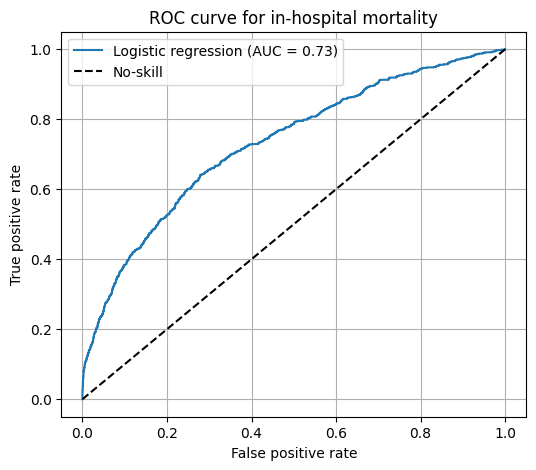

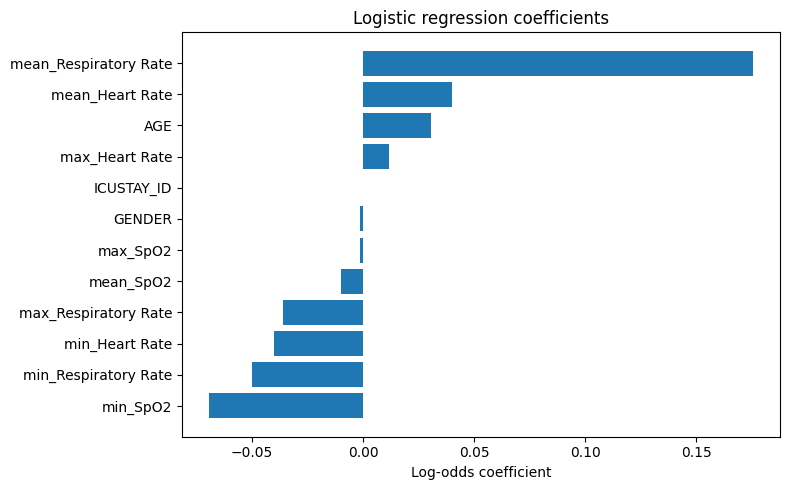

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic regression (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], "k--", label="No-skill")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve for in-hospital mortality")
plt.legend()
plt.grid(True)
plt.show()

# Coefficient bar plot
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": log_reg.coef_[0]
}).sort_values("coef", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(coef_df["feature"], coef_df["coef"])
plt.xlabel("Log-odds coefficient")
plt.title("Logistic regression coefficients")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


A logistic regression model was trained to predict in-hospital mortality using age, gender, and first-day vital signs (heart rate, respiratory rate, and oxygen saturation) for 36,519 ICU stays. On the held-out test set, the model achieved an accuracy of 0.90 and a ROC-AUC of 0.73, indicating moderate ability to discriminate between survivors and non-survivors. Compared with a simple majority-class baseline that predicts survival for all patients (accuracy 0.89, ROC-AUC 0.50), the logistic model provides clear added value by improving discrimination while maintaining similar overall accuracy.

The confusion matrix showed that the model correctly identified most survivors (specificity close to 1.0) but missed a substantial proportion of deaths, reflecting the strong class imbalance in the data. The baseline classifier never predicted death and therefore achieved zero recall for the mortality class, whereas the logistic regression captured a subset of high-risk patients at the expense of some false positives.

Coefficient inspection suggested that higher maximum and mean heart rate and higher respiratory rate were associated with increased mortality risk, whereas higher oxygen saturation was associated with decreased risk. These directions are clinically plausible: patients with tachycardia, tachypnea, and lower oxygenation tend to be more severely ill. However, the relatively modest ROC-AUC indicates that first-day vital signs alone are not sufficient for highly accurate mortality prediction, and incorporating additional clinical variables (e.g., laboratory values, comorbidities, and severity scores) would likely improve performance.